# Лабораторная работа 0

| Студент       | Ланин Олег                    | 
|-----------|------------------------------------|
| Группа  | М8О-301Б-19  |

### Задание

В данной лабораторной работе, вы выступаете в роли предприимчивого начинающего стартапера в области машинного обучения. Вы заинтересовались этим направлением и хотите  предложить миру что-то новое и при этом неплохо заработать. От вас требуется определить задачу которую вы хотите решить  и найти под нее соответствующие данные. Так как вы не очень богаты, вам предстоит руками проанализировать данные, визуализировать зависимости, построить новые признаки и сказать хватит ли вам этих данных, и если не хватит найти еще. Вы готовитесь представить отчет ваши партнерам и спонсорам, от которых зависит дальнейшая ваша судьба.

#### Данные
Есть три файла: (1) train.csv, (2) test.csv и (3) gender_submission.csv.

(1) train.csv
train.csv содержит сведения о подмножестве пассажиров на борту (891 пассажир, если быть точным - где каждый пассажир получает отдельную строку в таблице).
Значения во втором столбце ("Выжил") можно использовать для определения того, выжил ли каждый пассажир или нет:

если это "1", то пассажир выжил.
если это "0", то пассажир умер.

Например, первым пассажиром, указанным в train.csv, является мистер Оуэн Харрис Брэнд. Ему было 22 года, когда он погиб на "Титанике".

(2) test.csv
Используя данны, которые есть в train.csv, мы должны предсказать, выжили ли остальные 418 пассажиров на борту (в test.csv).

(3) gender_submission.csv
Файл gender_submission.csv предоставляется в качестве примера, который показывает, как вы должны структурировать свои прогнозы. Он предсказывает, что все пассажиры женского пола выжили, а все пассажиры мужского пола погибли. 


Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);

Name — имя;

Sex — пол;

Age — возраст;

SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;

Parch — количество родителей, детей (в том числе приемных) на борту титаника;

Ticket — номер билета;

Fare — плата за проезд;

Cabin — каюта;

Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон).

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
gen_submission = pd.read_csv('./gender_submission.csv')

df_test['Survived'] = gen_submission['Survived']

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Посмотрим на первичную информацию о данных.

In [4]:
df_train.shape

(891, 12)

In [26]:
df.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Survived', 'Relatives'], dtype='object')

In [5]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Значит, в табличке всего 891 запись и 12 столбцов. Один из них -- целевая переменная Survived. Она равна 1, если человек выжил, и 0, если нет.

Теперь посмотрим, есть ли пропуски в данных.

In [6]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
for col in df_train.columns:
    percent_of_missing_values = df_train[col].isnull().sum() / len(df_train[col]) * 100
    print(f'{col}: {round(percent_of_missing_values, 3)} %')

PassengerId: 0.0 %
Survived: 0.0 %
Pclass: 0.0 %
Name: 0.0 %
Sex: 0.0 %
Age: 19.865 %
SibSp: 0.0 %
Parch: 0.0 %
Ticket: 0.0 %
Fare: 0.0 %
Cabin: 77.104 %
Embarked: 0.224 %


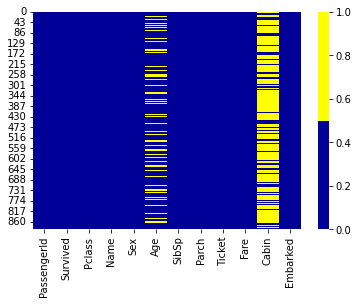

In [8]:
colors = ['#000099','#ffff00']
sns.heatmap(df_train.isnull(), cmap = sns.color_palette(colors))
plt.show()

In [9]:
# В столбце Cabin 77% данных пропущено, поэтому просто убираем его из рассмотрения
df_train = df_train.drop(columns=['Cabin'])
df_test = df_test.drop(columns=['Cabin'])

In [10]:
# Теперь, основываясь на стандартном отклонении возраста и его среднем значении, заполним пробелы в столбце Age
for df in [df_train, df_test]:
    mean = df['Age'].mean()
    std = df['Age'].std()
    number_of_nulls = df['Age'].isnull().sum()
    random_ages = np.random.randint(mean - std, mean + std, size=number_of_nulls)

    # Заменяем пропущенные значения сгенерированными числами
    new_ages = df['Age'].copy()
    new_ages[np.isnan(new_ages)] = random_ages
    df['Age'] = new_ages

In [11]:
# В Embarked всего лишь 2 пропуска, поэтому просто заполним их самым часто встречающимся значением
print(df_train['Embarked'].value_counts())

for df in [df_train, df_test]:
    df['Embarked'] = df['Embarked'].fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [12]:
print(df_train.isna().sum(), end='\n\n')
print(df_test.isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Survived       0
dtype: int64


In [13]:
# Уберём из df_test единственную запись, где пропущено значение Fare
df_test = df_test[df_test['Fare'].notnull()]

В таблице не осталось пропущенных значений. Займемся визуализацией и отбором признаков.

In [14]:
# Признак Name, скорее всего, не будет полезен при предсказании
# Могли бы быть полезны обращения типа Mrs., Mr., Miss., но у нас уже есть признаки с полом и возрастом
df['Name'].values[:20]

array(['Kelly, Mr. James', 'Wilkes, Mrs. James (Ellen Needs)',
       'Myles, Mr. Thomas Francis', 'Wirz, Mr. Albert',
       'Hirvonen, Mrs. Alexander (Helga E Lindqvist)',
       'Svensson, Mr. Johan Cervin', 'Connolly, Miss. Kate',
       'Caldwell, Mr. Albert Francis',
       'Abrahim, Mrs. Joseph (Sophie Halaut Easu)',
       'Davies, Mr. John Samuel', 'Ilieff, Mr. Ylio',
       'Jones, Mr. Charles Cresson',
       'Snyder, Mrs. John Pillsbury (Nelle Stevenson)',
       'Howard, Mr. Benjamin',
       'Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)',
       'del Carlo, Mrs. Sebastiano (Argenia Genovesi)',
       'Keane, Mr. Daniel', 'Assaf, Mr. Gerios',
       'Ilmakangas, Miss. Ida Livija',
       'Assaf Khalil, Mrs. Mariana (Miriam")"'], dtype=object)

In [15]:
# Дропнем имена и ID пассажиров
df_train = df_train.drop(columns=['Name', 'PassengerId'])
df_test = df_test.drop(columns=['Name', 'PassengerId'])

In [16]:
len(df['Ticket'].unique()) / len(df['Ticket'])

0.868421052631579

In [17]:
# Так как 76% значений в столбце Ticket уникальны, то он вряд ли даёт существенную информацию о целевой переменной
df_train = df_train.drop(columns=['Ticket'])
df_test = df_test.drop(columns=['Ticket'])

In [18]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,36.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


           Survived    Pclass       Sex       Age      Fare  Embarked  \
Survived   1.000000 -0.338481  0.543351 -0.069118  0.257307  0.106811   
Pclass    -0.338481  1.000000 -0.131900 -0.317699 -0.549500  0.045702   
Sex        0.543351 -0.131900  1.000000 -0.075826  0.182333  0.116569   
Age       -0.069118 -0.317699 -0.075826  1.000000  0.086114  0.000575   
Fare       0.257307 -0.549500  0.182333  0.086114  1.000000  0.062142   
Embarked   0.106811  0.045702  0.116569  0.000575  0.062142  1.000000   
Relatives  0.016639  0.065997  0.200988 -0.231849  0.217138 -0.080281   

           Relatives  
Survived    0.016639  
Pclass      0.065997  
Sex         0.200988  
Age        -0.231849  
Fare        0.217138  
Embarked   -0.080281  
Relatives   1.000000  


<AxesSubplot:>

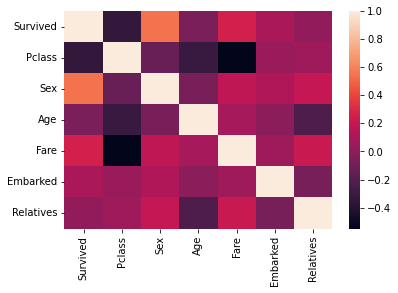

In [42]:
print(df_train.corr())
sns.heatmap(df_train.corr())

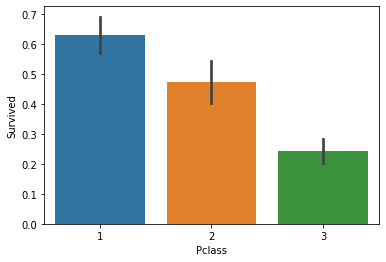

In [19]:
# Чем меньше номер класса, тем выше была вероятность выжить
sns.barplot(data=df_train, x='Pclass', y='Survived')
plt.show()

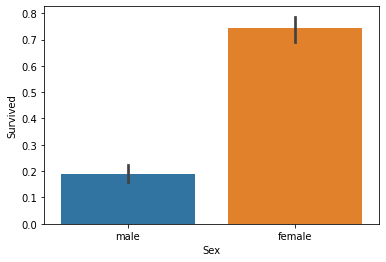

In [20]:
# У женщин, в среднем, вероятность выжить была заметно больше, чем у мужчин
sns.barplot(data=df_train, x='Sex', y='Survived')
plt.show()

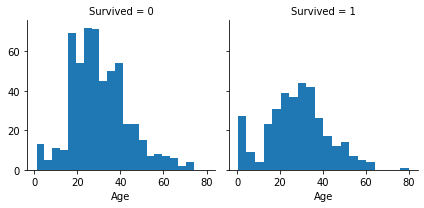

In [31]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

D:\anaconda\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


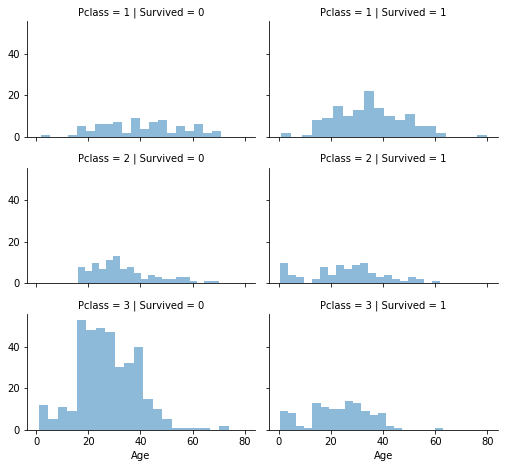

In [32]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

<AxesSubplot:xlabel='Age', ylabel='Survived'>

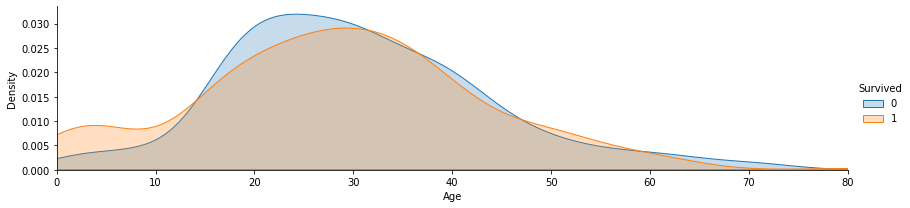

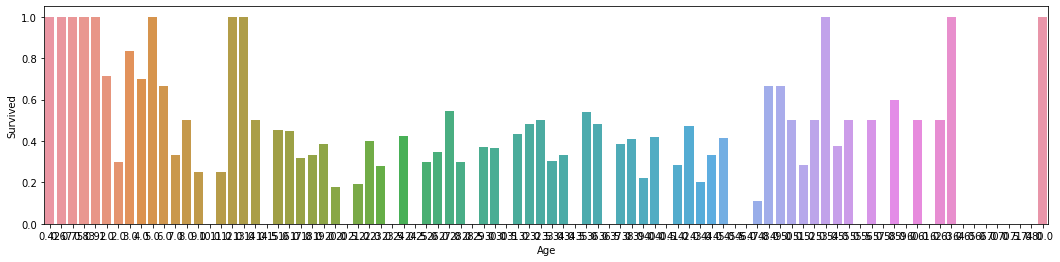

In [40]:
# пики для выживших/не выживших пассажиров по их возрасту
facet = sns.FacetGrid(df_train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_train['Age'].max()))
facet.add_legend()

# среднее число выживших пассажиров в разбивке по возрасту
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = df_train[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

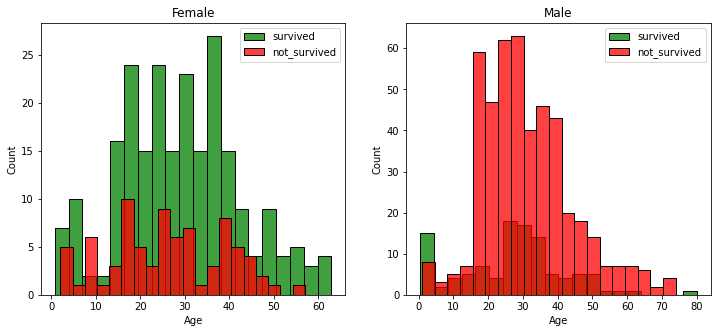

In [21]:
# Распределение для выживших и не выживших мужчин и женщин в зависимости от возраста
women_df = df_train[df_train['Sex']=='female']
men_df = df_train[df_train['Sex']=='male']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = sns.histplot(women_df[women_df['Survived']==1]['Age'], bins=20, label = 'survived', ax = axes[0], kde =False, color='green')
ax = sns.histplot(women_df[women_df['Survived']==0]['Age'], bins=20, label = 'not_survived', ax = axes[0], kde =False, color='red')
ax.legend()
ax.set_title('Female')

ax = sns.histplot(men_df[men_df['Survived']==1]['Age'], bins=20, label = 'survived', ax = axes[1], kde = False, color='green')
ax = sns.histplot(men_df[men_df['Survived']==0]['Age'], bins=20, label = 'not_survived', ax = axes[1], kde = False, color='red')
ax.legend()
ax.set_title('Male')
plt.show()

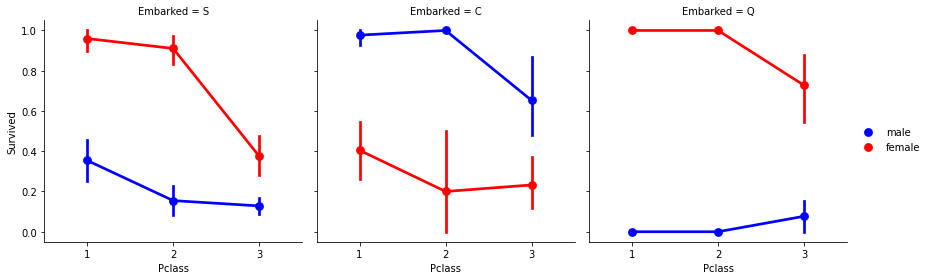

In [22]:
# Женщины, которые сели в порту S и Q выживали чаще, но чаще погибали, если садились в порту C.
# Мужчины имели больший шанс выжить, если сели в порту C, но чаще погибали, если садились в порту S и Q.

grid = sns.FacetGrid(df_train, col='Embarked', height=4, aspect=1)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=['blue', 'red'], order=None, hue_order=None )
grid.add_legend()
plt.show()

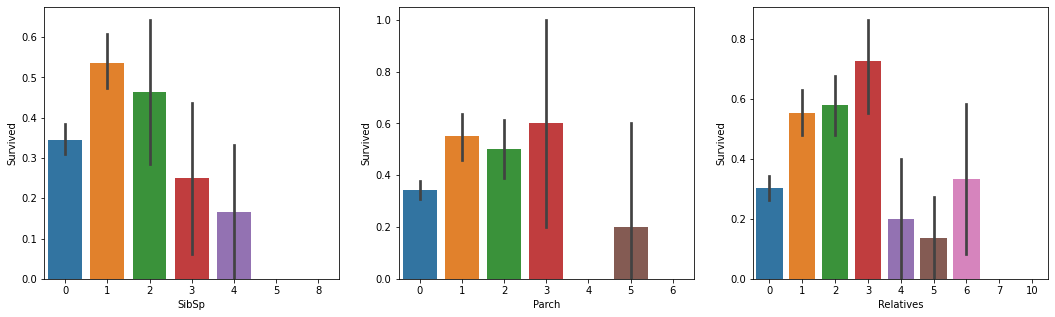

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = sns.barplot(data=df_train, x='SibSp', y='Survived', ax=axes[0])
ax = sns.barplot(data=df_train, x='Parch', y='Survived', ax=axes[1])

df_train['Relatives'] = df_train['Parch'] + df_train['SibSp']
ax = sns.barplot(data=df_train, x='Relatives', y='Survived', ax=axes[2])
plt.show()

# Мы видим, что, в среднем, люди с 1-3 родственниками на борту выживают чаще. Заменим Parch и SibSp на Relatives для уменьшения количества признаков
df_test['Relatives'] = df_test['Parch'] + df_test['SibSp']
df_train = df_train.drop(columns=['SibSp', 'Parch'])
df_test = df_test.drop(columns=['SibSp', 'Parch'])

In [24]:
# Преобразуем признаки Sex и Embarked
genders = {'male': 0, 'female': 1}
ports = {"S": 0, "C": 1, "Q": 2}

for df in [df_train, df_test]:
    df['Sex'] = df['Sex'].map(genders)
    df['Embarked'] = df['Embarked'].map(ports)

Матрица корреляции

<AxesSubplot:>

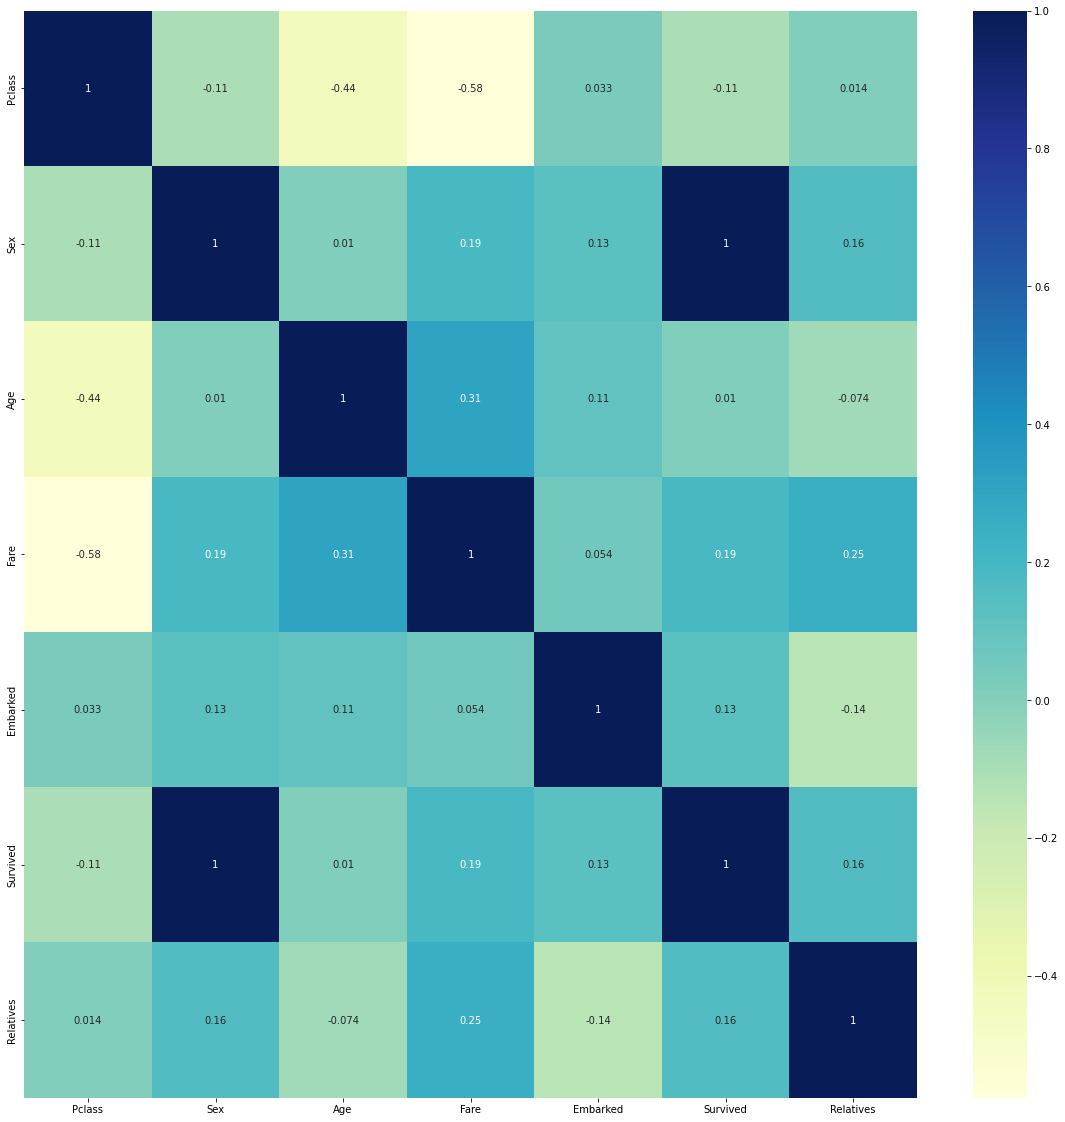

In [41]:
plt.figure(figsize = (20, 20))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

In [25]:
# Формируем тренировочные и тестовые данные
X_train = df_train.drop(columns=['Survived'])
Y_train = df_train['Survived']

X_test = df_test.drop(columns=['Survived'])
Y_test = df_test['Survived']

df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Survived,Relatives
0,3,0,34.5,7.8292,2,0,0
1,3,1,47.0,7.0000,0,1,1
2,2,0,62.0,9.6875,2,0,0
3,3,0,27.0,8.6625,0,0,0
4,3,1,22.0,12.2875,0,1,2


В данной части лабораторной работы мной был найден датасет титаник для определениявыживыет человек или нет. Я подготовил данные для решения задачи классификации по параметрам.

Для меня задание оказалось очень сложным.